# Sanity Check: 2019 SLC totals against other inventories

In [1]:
#Import packages
import xarray as xr
import pandas as pd
import os
import pyproj
import numpy as np
import xesmf as xe
import calendar
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import sys
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature


sys.path.append('..')
import noaa_csl_funcs as ncf

In [2]:
#Define Classes and Functions
class Regridded_CSL_Handler:
    '''A class to handle NOAA CSL inventory data that has been regridded and organized by regrid_data.py'''

    def __init__(self,regridded_path,bau_or_covid='COVID'):
        '''Everything revolves around the "regridded_path", which determines sectors via the filenames contained within'''

        self.regridded_path = regridded_path
        self.sectors = self.get_sectors()
        self.bau_or_covid = bau_or_covid

    def get_sectors(self):
        '''Lists the sectors in the regridded data storage path'''

        sector_list = ncf.listdir_visible(self.regridded_path)
        sectors = {'area':[],'point':[]}
        for sector in sector_list:
            if 'area' in sector:
                sectors['area'].append(sector)
            elif 'point' in sector:
                sectors['point'].append(sector)
            else:
                raise ValueError(f"Unexpected sector type {sector}, not point or area.")
        return sectors

    def get_sector_subset_list(self,sector_subset):
        '''Gets a subset of the sectors which could be one, all, or some
        
        Args:
        sector_subset (str,list): "all" will return all sectors,  'point' will return point sectors, 'area' will return area sectors, a list will just return that list
        
        Returns:
        sector_subset_list (list) : list of sectors in the subset. 
        '''

        if sector_subset == 'all':
            sector_subset_list = []
            for k,v in self.sectors.items():
                sector_subset_list.extend(v)
            return sector_subset_list
        elif type(sector_subset)==str:
            return self.sectors[sector_subset]
        else:
            return sector_subset

    def get_days_in_range(self,dt1,dt2,day_types,sector_subset = 'all',add_path=True):
        '''Gets all filepaths to the day_type level that are within a datetime range
        
        Args:
        dt1 (datetime.date) : a date, datetime, etc to start the range (will only use year and month)
        dt2 (datetime.date) : a date, datetime, etc to end the range (will only use year and month)
        sectors (list) : list of sectors to include in the list
        day_types (list) : list of day types to include in the list
        add_path (bool, optional) : if true (default) it will add the regridded path to each element

        Returns:
        days_in_range (list) : list of paths to files that are within the date range and sector, day_types, etc. 
        '''

        dates_list = pd.date_range(dt1,dt2,freq = 'MS') #get a list of all the months between the dts
        sector_subset_list = self.get_sector_subset_list(sector_subset)
        days_in_range = []
        for date in dates_list:
            for sector in sector_subset_list:
                for day_type in day_types:
                    day_path = f'{sector}/{ncf.yr_to_yrstr(sector,date.year,self.bau_or_covid)}/{ncf.month_int_to_str(date.month)}/{day_type}'
                    if add_path:
                        days_in_range.append(os.path.join(self.regridded_path,day_path))
                    else:
                        days_in_range.append(day_path)
        return days_in_range
    
    def get_files_in_days(self,days_paths):
        '''Gets the files that exist in the paths
        
        Args:
        days_path (list) : list of paths to the days folders
        
        Returns:
        files (list) : list of files in those days' paths'''

        files = []
        for day_path in days_paths:
            files.extend(ncf.listdir_visible(day_path,add_path=True))
        return files


#Define Functions
def preprocess_regridded(ds,extent=None):
    '''Preprocesses the regridded dataset when loaded to add attributes needed for concatenation
    
    Args:
    ds (xr.DataSet) : the dataset to process
    extent (dict) : a dictionary with 4 elements defining the bounding box -- must include 'lat_min', 'lat_max', 'lon_min', 'lon_max'. These are inclusive. Defaults to "None" which will return the whole ds
    
    Returns 
    ds (xr.DataSet) : the dataset, with added coordinates taken from the attributes, sliced to the input extent
    '''

    grid_type = ds.attrs['grid_type']
    if grid_type == 'area':
        ds = ds.assign_coords(sector = 'area_'+ ds.attrs['sector_id']) #add back the area, was cut off in attributes for some reason
    elif grid_type == 'point':
        ds = ds.assign_coords(sector = 'point_'+ ds.attrs['sector_id']) #add back the point, was cut off in attributes for some reason

    ds = ds.assign_coords(day_type = ds.attrs['day_type']) #assign the day_type coordinate
    ds = ds.assign_coords(yr_mo=f'{ds.attrs['year']}-{ds.attrs['month']}') #assign the year/month coordinate
    ds = ds.expand_dims(dim=['sector','day_type','yr_mo']) #make the coordinates into dimensions
    if extent is not None:
        ds = slice_extent(ds,extent) #slice to the bounding box extent

    try:
        del ds.attrs['nc_fpath'] #we don't need this attribute -- it points to an old nc path. 
    except:
        pass

    return ds

def slice_extent(ds,extent):
    '''Slice a dataset to a bounding box defined by the extent argument
    
    Args:
    ds (xr.DataSet) : the dataset to process
    extent (dict) : a dictionary with 4 elements defining the bounding box -- must include 'lat_min', 'lat_max', 'lon_min', 'lon_max' -- inclusive.

    Returns:
    ds (xr.DataSet) : the dataset clipped to within the extent range
    '''

    try:
        grid_type = ds.attrs['grid_type']
    except:
        grid_type = 'area'
    if grid_type == 'area': #if it's an area grid
        ds = ds.sel(lat=slice(extent['lat_min'],
                              extent['lat_max']),
                    lon=slice(extent['lon_min'],
                              extent['lon_max'])) #we can slice on the lat lon coordinates
    elif grid_type == 'point': #if it's a point grid
        ds = ds.where(((ds.lat>=extent['lat_min'])&
                       (ds.lat<=extent['lat_max'])&
                       (ds.lon>=extent['lon_min'])&
                       (ds.lon<=extent['lon_max'])).compute(),drop=True) #we have to select the individual points using .where, and compute them. The drop term gets rid of NA's not in the extent
    else: 
        raise TypeError('Did not recognize the grid type, unsure how to slice')
    
    return ds 

def ncount_satsunwkd(year,month):
    '''Gets the number of saturdays, sundays and weekdays in a given month/year
    
    Args:
    year (int) : the year
    month (int) : the month, as an integer
    
    Returns:
    sat_count (int) : number of saturdays
    sun_count (int) : number of sundays
    weekd_count (int) : number of weekdays
    '''

    num_days_in_month = calendar.monthrange(year,month)[1]
    month_str = f'{month:02d}'

    dow_ints = list(pd.date_range(start=f'{year}-{month_str}-01',end=f'{year}-{month_str}-{num_days_in_month}').weekday)
    sat_count = len([ dow for dow in dow_ints if dow == 5 ])
    sun_count = len([ dow for dow in dow_ints if dow == 6 ])
    weekd_count = len([ dow for dow in dow_ints if dow < 5 ])
    return sat_count,sun_count,weekd_count

### Functions for loading and dealing with other inventories
def load_edgar_nc(edgar_path,spec,emi_or_flx,year):
    if spec in ['CH4','CO2']:
        nc_folder_name = f'v8.0_FT2022_GHG_{spec}_{year}_TOTALS_{emi_or_flx}_nc'
        nc_file_name = '_'.join(nc_folder_name.split('_')[:-1]) + '.nc'
    elif spec == 'CO':
        nc_folder_name = f'EDGARv6.1_{spec}_{year}_TOTALS.0.1x0.1'
        nc_file_name = (nc_folder_name) + '.nc'

    nc_fullpath = os.path.join(edgar_path,spec,emi_or_flx,nc_folder_name,nc_file_name)
    try:    
        ds = xr.open_dataset(nc_fullpath)
    except FileNotFoundError as f:
        print(f)
        raise FileNotFoundError(f'There doesnt seem to be data for this configuration:{spec},{emi_or_flx},{year}')
    if spec == 'CO':
        ds = coord_change_360_180(ds)
        ds = ds.rename({'emi_co':'fluxes'})
        ds['fluxes'].attrs['substance'] = 'CO'

    gca_fname = nc_file_name.split('.nc')[0] + '_gca' + '.nc'
    try:
        gca_fullpath = os.path.join(edgar_path,spec,emi_or_flx,nc_folder_name,gca_fname)
        gca_ds = xr.open_dataset(gca_fullpath)
        if spec == 'CO':
            gca_ds = coord_change_360_180(gca_ds)
        ds = add_gca_to_ds(ds,gca_ds)
    except FileNotFoundError:
        print(f'No grid cell area file {gca_fullpath} found. Create with cdo to use. Returning ds without gca')
        return ds

    return ds

def coord_change_360_180(ds):
    return ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')

def add_gca_to_ds(orig_ds,gca_ds):
    orig_ds['grid_cell_area'] = gca_ds['cell_area']
    return orig_ds

def load_epa_nc(path,year):
    fname = f'Express_Extension_Gridded_GHGI_Methane_v2_{year}.nc'
    ds = xr.open_dataset(os.path.join(path,fname))
    name_map = {k: k.replace('emi','flx') for k in ds} #in the nc file, the data variables are names "emi..." which is confusing as they are fluxes. so rename to flx...
    ds = ds.rename(name_map)
    return ds    

In [3]:
#This is the main function to get a yearly sum from the input criteria. 

def get_yearsum(RCH,year,sectors,species,extent):
    dt1 = f'{year}-01'
    dt2 = f'{year}-12'
    day_types = ['weekdy','satdy','sundy'] 
    #Get the paths to the files that match the criteria
    days_paths = RCH.get_days_in_range(dt1,dt2,day_types,sectors) #get the paths
    files = RCH.get_files_in_days(days_paths) #get the days

    #Load the files with xarray, preprocessing them so they can be combined by coordinates
    ds_list = [] #initialize the list of datasets
    for file in files:
        ds = preprocess_regridded(xr.open_dataset(file,chunks = {'utc_hour':1}),extent)[species] #prepreprocess the file, open with dask chunking, and only keep the species of interest
        ds_list.append(ds) #append each to the list
    ds_combined = xr.combine_by_coords(ds_list,combine_attrs='drop_conflicts') #this is the combined dataset!
    mass_unit = ds_combined[species].attrs['units'].split()[0] #this will either be metric_Ton or moles depending on the species chosen

    # sum on utc_hour and sector first -- can sum on utc hour because the units 
    # are in "per hour", so this should be "per day" as the new unit indicates
    ds = ds_combined.sum(dim=['utc_hour','sector'])[species].assign_attrs({'units':f'{mass_unit} day^-1 meters^-2'}) 

    #now sum on the months, one by one
    month_sums = []  #initialize the months lists so we can recombine them
    for yr_mo in ds.yr_mo.values: #loop through the months
        yr = int(yr_mo.split('-')[0]) #get the year int
        mo = int(yr_mo.split('-')[1]) #get the mnoth int
        sat,sun,wkdy = ncount_satsunwkd(yr,mo) #for that year and month, get the number of saturdays, sundays, and weekdays

        #for each daytype, multiply the values for that day type by the number of that type of days in that month
        sat_sum = (ds.sel(yr_mo=yr_mo,day_type='satdy')*sat).assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})
        sun_sum = (ds.sel(yr_mo=yr_mo,day_type='sundy')*sun).assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})
        wkdy_sum = (ds.sel(yr_mo=yr_mo,day_type='weekdy')*wkdy).assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})

        #this is the sum of the month --
        #first combine on day_type -- this causes the daytypes to be represented as variables
        #then sum on the variables, and drop the daytype variables, and reassign the units
        month_sum = xr.combine_by_coords([sat_sum.to_dataset(name='sat'),
                                        sun_sum.to_dataset(name='sun'),
                                        wkdy_sum.to_dataset(name='wkdy')
                                        ],compat='override').to_array().sum("variable").drop_vars('day_type').assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})
        
        month_sums.append(month_sum.to_dataset(name=yr_mo)) # append each month sum to the list so we can rejoin them

    #now get the yearsum by combining on the month sums and doing a similar process to above (summing on variables and dropping)
    yr_sum = xr.combine_by_coords(month_sums,compat='override').to_array().sum("variable").drop_vars('yr_mo').assign_attrs({'units':f'{mass_unit} meters^-2'})
    return yr_sum


## Define Parameters

In [156]:
map_extent={'lon_min':-112.25,
            'lon_max':-111.55,
            'lat_min':40.3,
            'lat_max':41.1} 
dataset_extent = {'lon_min':-112.15,
                  'lon_max':-111.7,
                  'lat_min':40.4,
                  'lat_max':41.0} 
regridded_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded'
RCH = Regridded_CSL_Handler(regridded_path)
year = 2019

## CH4: (HC01)

In [157]:
species = 'HC01' #methane
sector_types = ['area','point']
yr_summed_ds_dict = {}

for sectors in sector_types:
    yr_sum = get_yearsum(RCH,year,sectors,species,dataset_extent) #get the total year sum from the 
    mass_unit = yr_sum.attrs['units'].split()[0]

    if sectors == 'area':
        #the yearsum is in flux units for area sources, need to multiply by grid area to get absolute units per grid cell
        grid_area = xr.open_dataset('../regridding/grid_area/grid_out_area.nc')  #load the gridcell area file
        grid_area = slice_extent(grid_area,dataset_extent) #slice it to the same extent
        absolute_emissions = (yr_sum * grid_area['cell_area']).assign_attrs({'units':mass_unit}) #multiply by the yearsum
    elif sectors == 'point':
        absolute_emissions = yr_sum.to_dataset(name=species)
    
    yr_summed_ds_dict[sectors] = absolute_emissions

In [159]:
point_df = yr_summed_ds_dict['point'][species].to_dataframe()
area_ds = yr_summed_ds_dict['area'].load()

In [26]:
point_df_grouped = point_df.groupby(['lat','lon']).sum().reset_index()
point_df_grouped[species].sum()

30180452.0

In [160]:
def get_point_sum_in_gc(row,point_df):
    subpointdf = point_df.loc[(point_df['lat'] >= row['lat_min'])&
                 (point_df['lat'] <= row['lat_max'])&
                 (point_df['lon'] >= row['lon_min'])&
                 (point_df['lon'] <= row['lon_max'])]
    return subpointdf['HC01'].sum()

In [161]:
cellsize = 0.1
df = area_ds.to_dataframe(name=species).reset_index()
df['lat_min'] = df.apply(lambda row: row['lat']-cellsize/2,axis = 1)
df['lat_max'] = df.apply(lambda row: row['lat']+cellsize/2,axis = 1)
df['lon_min'] = df.apply(lambda row: row['lon']-cellsize/2,axis = 1)
df['lon_max'] = df.apply(lambda row: row['lon']+cellsize/2,axis = 1)


df['point_sum'] = df.apply(lambda row: get_point_sum_in_gc(row,point_df),axis = 1)
df['point_sum'].sum()

30334310.0

In [162]:
point_df[species].sum()

30334310.0

In [121]:
import geopandas as gpd
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata # Different choices here
import json
from shapely.geometry import box, mapping


point_gdf = gpd.GeoDataFrame(point_df_grouped, 
                      geometry=gpd.points_from_xy(point_df_grouped.lon, point_df_grouped.lat, 
                      crs=4326))

geo_grid = make_geocube(
    vector_data=point_gdf,
    measurements=['HC01'],
    geom=json.dumps(mapping(box(-112.1, 40.4, -111.75, 40.9))),
    output_crs="epsg:4326",
    resolution=(-0.1,0.1),
    align=(0.05,0.05),
    #rasterize_function=rasterize_points_radial,
)
geo_grid.to_dataframe()#[species].sum()

HC01  spatial_ref
y    x                                
40.9 -112.1           NaN            0
     -112.0           NaN            0
     -111.9      0.000000            0
     -111.8           NaN            0
40.8 -112.1           NaN            0
     -112.0   5687.941895            0
     -111.9      0.000000            0
     -111.8  41998.503906            0
40.7 -112.1      0.000000            0
     -112.0      0.000000            0
     -111.9   2802.748535            0
     -111.8           NaN            0
40.6 -112.1  30133.945312            0
     -112.0  89339.507812            0
     -111.9      0.000000            0
     -111.8           NaN            0
40.5 -112.1           NaN            0
     -112.0           NaN            0
     -111.9  50035.886719            0
     -111.8           NaN            0
40.4 -112.1           NaN            0
     -112.0           NaN            0
     -111.9      0.000000            0
     -111.8      0.000000            0

In [119]:
point_gdf[species].mean()

486781.47

In [100]:
point_df[species].sum()

30180452.0

In [101]:
geo_grid[species].sum().values

array(219998.53, dtype=float32)

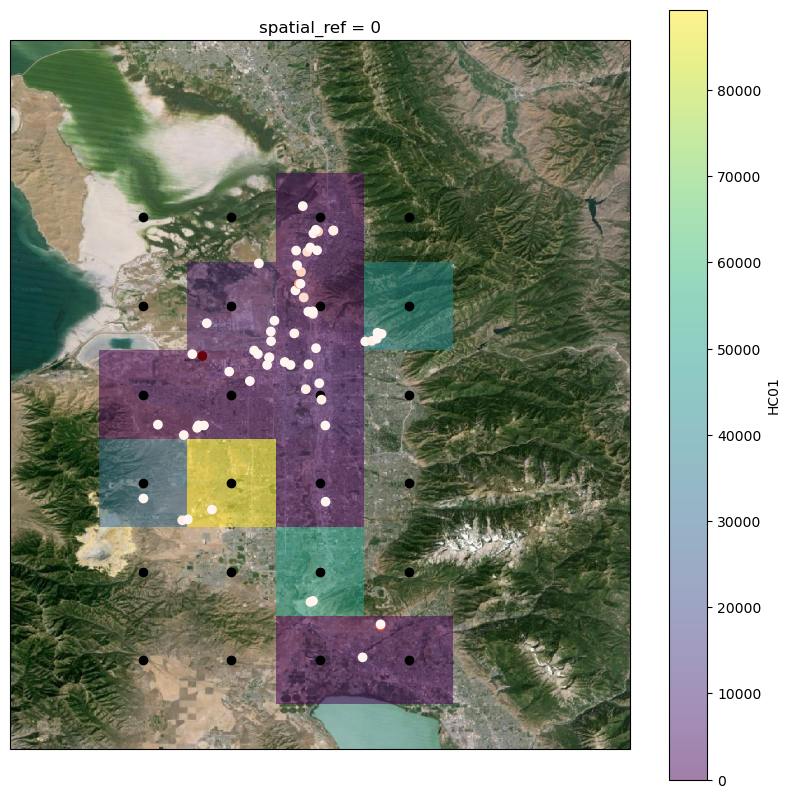

In [116]:
labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = proj)

ax.set_extent([map_extent['lon_min'],map_extent['lon_max'],map_extent['lat_min'],map_extent['lat_max']],crs=proj)
request = cimgt.GoogleTiles(style='satellite')
scale = 11.0 # prob have to adjust this
ax.add_image(request,int(scale))

geo_grid[species].plot.pcolormesh('x','y',ax=ax,alpha = 0.5)
ax.scatter(geo_grid.to_dataframe().reset_index()['x'],geo_grid.to_dataframe().reset_index()['y'],color = 'k')
sc = ax.scatter(point_df_grouped.lon,point_df_grouped.lat,c=point_df_grouped[species],cmap='Reds')
#plt.colorbar(sc)
#area_ds.plot.pcolormesh('lon','lat',ax=ax,alpha = 0.5)
plt.show()

In [15]:
total_sum = point_df[species].sum() + area_ds.sum().values
print(f'Total {species} emissions for the bounded region for {year}')
if (mass_unit == 'mole') & (species == 'HC01'):
    print(total_sum*16.04/1E6,'metric_Ton',species) #multiply moles by grams per mole, divide by 1E6 grams per metric ton
elif (mass_unit == 'mole') & (species != 'HC01'):
    print('have to deal with the molecular mass of this still')
else:
    print(total_sum,mass_unit,species)

Total HC01 emissions for the bounded region for 2019
20319.97899573494 metric_Ton HC01
